# Introduction
In this project, we are asked to analyze a dataset and answer some questions from the dataset. I'll choose the Titanic dataset to discover if survival rate differs in gender, class and age. 
Questions need to solve:
   1. If survival rate is different within class.
   2. If survival rate is different within gender.
   3. If survival rate is different within different age groups.

# Starting the analysis

### 1. Data wrangling

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math
%matplotlib inline

In [2]:
#import dataset
dt = pd.read_csv('train.csv')

In [3]:
#show the data
dt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Handle missing value
We can see there're three features that have missing values - Age,Cabin and Embarked
Age has 177 missing value, Cabin has 687 and Embarked has 2 missing values.

In [4]:
#check if there're missing values
dt.isnull().sum(0)
#we can see 3 variables have missing values - Age, Cabin and Embarked

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

For Age, I would simply apply the average to replace the Null values because  1. I consider it as a continuous variable when doing the analysis. 2. Mean is a good point estimate of the missing values.

In [5]:
#1. Age. Because its continuous, i decide to use mean as a substitute for the missing values.
mean_age = dt[dt['Age'].isnull() == False]['Age'].mean()

dt['Age'] =dt['Age'].apply(lambda x: x if math.isnan(x) == False else mean_age)

For Embarked, its categorial and only 2 nans, by observation, i found that these two passengers have the same ticket number and in the same cabin and there're no other passengers have the same cabin and ticket. So i decide to replace with the place where most people embarked - which is S.

In [6]:
#2. Embarked. its categorial and only 2 nans, by observation, i found that these two passengers have the same ticket number and 
    #in the same cabin and there're no other passengers have the same cabin and ticket. So i decide to replace with the place where most
    #people embarked - which is S.
dt[dt['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
dt[(dt['Cabin'] == 'B28') | (dt['Ticket'] == 113572)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
#S is the most popular place to embark.
dt.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [9]:
dt['Embarked'] =dt['Embarked'].apply(lambda x: x if x  not in ['C','Q','S'] else 'S')

For Cabin, Because its categorical and it have many nans, i'll directly replace with a new group called 'unknown'. There're no way of applying average or weighted average since its categorical.

In [10]:
#3. Cabin. Its categorical and it have many nans, i'll directly replace with a new group called 'unknown'

def na_cabin(x):
    if pd.isnull(x['Cabin']):
        return 'unknown'
    else:
        return x['Cabin']


dt['Cabin'] =dt.apply(na_cabin,axis = 1)

In [11]:
dt.shape

(891, 12)

In [12]:
# Leave only relevant features in the dataset 
dt = dt[['Survived','Pclass','Sex','Age']]

Because i only want to analyze of Pclass, Sex and Age would influence the survival rate, i'll only leave the above 4 columns

In [13]:
#check dimension of data
dt.shape

(891, 4)

In [14]:
#convert age into bucket and fill NA with 'unknown'

#find the max age in order to bucket the age
max(dt['Age'])

80.0

In [15]:
#function of bucket age
def age_bucket(x):
    if x <= 10:
        return '0-10'
    elif x <= 20:
        return '11-20'
    elif x <= 30:
        return '21-30'
    elif x <= 40:
        return '31-40'
    elif x <= 50:
        return '41-50'
    elif x <= 60:
        return '51-60'
    elif x <= 70:
        return '61-70'
    elif x <= 80:
        return '71-80'
    else:
        return 'unknown'

In [16]:
#turn age into bucket
dt['age_bucket'] = dt['Age'].apply(age_bucket)

Only missing values in Age, when i analyze Ages, i'll bucket it into different groups and eliminate null values.

### 2. Analyzing the dataset

#### 2.1 Does survival rate differ within different classes?

In [17]:
#count of passengers by class
dt.groupby('Pclass').Survived.size()

Pclass
1    216
2    184
3    491
dtype: int64

All 3 groups have enough samples, so its doable to apply the hypothesis test.
Because what we test is a categorical variable, i'll apply chi-square test.

##### H0: No difference of survival rate within class
##### HA: There're differences of survival rate within class

In [18]:
#survival rate by class
dt.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

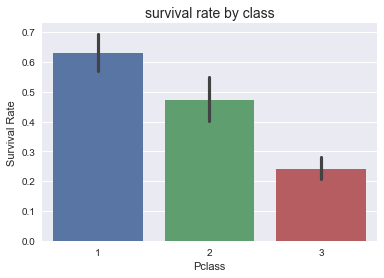

In [20]:
#plot survival rate by class
bcp = sns.barplot(x="Pclass", y="Survived", data=dt)
bcp.set_title("survival rate by class",fontsize=14)
bcp.set_ylabel("Survival Rate")

i wanna know the difference of survival rate among classes and from the above plot, i found that class 1 has the highest rate, which not surprise me becuase it fit with my assumptions that upper class will survive more.

In [21]:
#perform the chisq test in python using scipy
res = stats.chi2_contingency(pd.crosstab([dt['Survived']], dt['Pclass']).values)
p_value = res[1]
p_value

4.5492517112987927e-23

Because p value < 0.05, we can say that we're able to reject the hypthesis that no difference by class. And from the plot above,we see that the higher the class(1) the higher the survival rate.

#### 2.2 Does survival rate differ within gender?

In [22]:
#count of passengers by gender
dt.groupby('Sex').Survived.size()

Sex
female    314
male      577
dtype: int64

Both groups have enough samples, so its doable to apply the hypothesis test.
Chi-square test in contingency table will also be applied.

##### H0: No difference of survival rate within gender
##### HA: There're differences of survival rate within gender

In [23]:
#survival rate by gender
dt.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

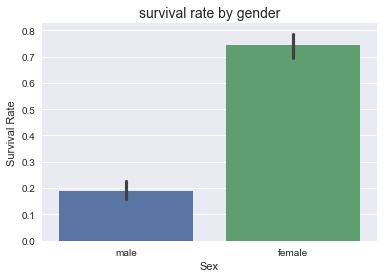

In [24]:
#plot survival rate by gender
bcp = sns.barplot(x="Sex", y="Survived", data=dt)
bcp.set_title("survival rate by gender",fontsize=14)
bcp.set_ylabel("Survival Rate")

i wanna know the difference of survival rate between male and female and from the above plot, i found that female has the highest rate, which not surprise me becuase it fit with my assumptions that seats in the lifeboats were given to female first.

In [25]:
#perform the chisq test in python using scipy
res = stats.chi2_contingency(pd.crosstab([dt['Survived']], dt['Sex']).values)
p_value = res[1]
p_value

1.1973570627755645e-58

Because p value < 0.05, we can say that we're able to reject the hypthesis that no difference by gender. 
And from the plot above,we see that female survival rate is significantly higher than male.

#### 2.2 Does survival rate differ within age groups?

In [26]:
#count of passengers by age bucket
dt.groupby('age_bucket').Survived.size()

age_bucket
0-10      64
11-20    115
21-30    407
31-40    155
41-50     86
51-60     42
61-70     17
71-80      5
dtype: int64

Because samples with age between 71-80 is too small(only 5), we group 61-80 as a group.

In [27]:
#function of bucket age
def age_bucket(x):
    if x <= 10:
        return '0-10'
    elif x <= 20:
        return '11-20'
    elif x <= 30:
        return '21-30'
    elif x <= 40:
        return '31-40'
    elif x <= 50:
        return '41-50'
    elif x <= 60:
        return '51-60'
    elif x <= 80:
        return '61-80'
    else:
        return 'unknown'

#turn age into bucket
dt['age_bucket'] = dt['Age'].apply(age_bucket)

In [28]:
#count of passengers by age bucket
dt.groupby('age_bucket').Survived.size()

age_bucket
0-10      64
11-20    115
21-30    407
31-40    155
41-50     86
51-60     42
61-80     22
dtype: int64

Since now each bucket group has sample size > 10, i'll apply the same chi-square test to the data.
When applying the test, age bucket 'Unknown' will be eliminated because we don't know the exact age of those passengers and i think applying any predictions like average or knn will bias the test. 

##### H0: No difference of survival rate within age bucket
##### HA: There're differences of survival rate within age bucket

In [29]:
#survival rate by age bucket
dt[dt['age_bucket'] != 'unknown'].groupby('age_bucket').Survived.mean()

age_bucket
0-10     0.593750
11-20    0.382609
21-30    0.334152
31-40    0.445161
41-50    0.383721
51-60    0.404762
61-80    0.227273
Name: Survived, dtype: float64

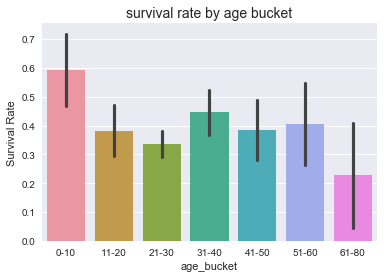

In [30]:
#plot survival rate by age bucket
bcp = sns.barplot(x="age_bucket", y="Survived", data=dt[dt['age_bucket'] != 'unknown']
                  ,order = ['0-10','11-20','21-30','31-40','41-50','51-60','61-80'])
bcp.set_title("survival rate by age bucket",fontsize=14)
bcp.set_ylabel("Survival Rate")

i wanna know the difference of survival rate across age groups and from the above plot, i found that child(0-10 yr old) has the highest rate, which not surprise me becuase it fit with my assumptions that seats in the lifeboats were given to children first.

In [31]:
#perform the chisq test in python using scipy
res = stats.chi2_contingency(pd.crosstab([dt[dt['age_bucket'] != 'unknown']['Survived']], dt[dt['age_bucket'] != 'unknown']['age_bucket']).values)
p_value = res[1]
p_value

0.0018382377886304599

Because p value < 0.05, we can say that we're able to reject the hypthesis that no difference by age bucket. And from the plot above,we see that passengers from 0-10 yr old has the highest survival rate while whose age higher than 60 has the lowest survival rate. 

#### 2.2 Are there any interactions between Age and Gender?

Based on the above analysis, we see that female or child(0-10) tend to have a higher survival rate. Now, i'll try to find if female child has a higher survival rate than other combinations.

In [32]:
pdt = dt.groupby(['Sex','age_bucket']).Survived.mean().to_frame()
pdt.reset_index(inplace=True)  

In [33]:
pdt

,Sex,age_bucket,Survived
0,female,0-10,0.612903
1,female,11-20,0.739130
2,female,21-30,0.723881
3,female,31-40,0.836364
4,female,41-50,0.677419
5,female,51-60,0.928571
6,female,61-80,1.000000
7,male,0-10,0.575758
8,male,11-20,0.144928
9,male,21-30,0.142857


In [34]:
print dt.groupby(['Sex','age_bucket']).Survived.mean()

Sex     age_bucket
female  0-10          0.612903
        11-20         0.739130
        21-30         0.723881
        31-40         0.836364
        41-50         0.677419
        51-60         0.928571
        61-80         1.000000
male    0-10          0.575758
        11-20         0.144928
        21-30         0.142857
        31-40         0.230000
        41-50         0.218182
        51-60         0.142857
        61-80         0.105263
Name: Survived, dtype: float64


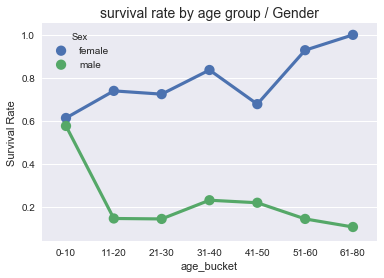

In [35]:
ax = sns.pointplot(x="age_bucket", y="Survived",hue="Sex", data=pdt)
ax.set_title("survival rate by age group / Gender",fontsize=14)
ax.set_ylabel("Survival Rate")

From the line plot above, we can see that female child(0-10 yr old) did has the highest survival rate. and Female in each age bucket has a higher survival rate than male.

# Summary
In this project, i answered 3 questions about if survival rate is impacted by gender, class and age group.
I applied the chi square test in contingency table to test if survival rate is different within each subgroups and by also looking at bar charts of survival rate i found out which subgroup has a higher survival rate.

From the above analysis, we see that survival rate is different within gender, class and age groups. Female has higher survival rate than male, upper class has higher survival rate than middle and lower class, 0-10 yr old passengers has higher survival rate than other age groups.

limitations:

1. missing data. missing value in age could bias our analysis.
2. we only been a sample of the data, this could also skew the result.

Future work:
1. For age missing values, try other methodologies liek knn to have a better replacement of the nans.
1. Try to get more data to conduct the analysis to reduce bias.